In [1]:
import os

GPU_ID = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID

import sys
sys.path.append('/home/rustam/hyperspecter_segmentation/makitorch')
sys.path.append('/home/rustam/hyperspecter_segmentation/')
KFOLD = 'kfold0'
PREFIX_INFO_PATH = f'/home/rustam/hyperspecter_segmentation/danil_cave/kfolds_data_with_other/{KFOLD}'
PATH_DATA = '/raid/rustam/hyperspectral_dataset/new_cropped_hsi_data'

CUT_WINDOW = (128, 128)

import random
from multiprocessing.dummy import Pool
from multiprocessing import shared_memory
import copy
from makitorch import *
from makitorch.dataset_remapper import DatasetRemapper
import math
import numpy as np
import numba as nb
import comet_ml
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torchvision import utils
import cv2
from Losses import FocalLoss
import matplotlib.pyplot as plt

import seaborn as sns
import json
from tqdm import tqdm

from sklearn.decomposition import PCA
from makitorch.architectures.U2Net import U2Net

from hsi_dataset_api import HsiDataset

from makitorch.dataloaders.HsiDataloader import HsiDataloader
from makitorch.architectures.Unet import Unet, UnetWithFeatureSelection
from makitorch.loss import muti_bce_loss_fusion
from sklearn.metrics import jaccard_score
np.set_printoptions(suppress=True)


from makitorch.data_tools.augmentation import DataAugmentator
from makitorch.data_tools.augmentation import BaseDataAugmentor
from makitorch.data_tools.preprocessing import BaseDataPreprocessor
from makitorch.data_tools.preprocessing import DataPreprocessor

from typing import Callable, Optional, Union, Dict

import torch
from sklearn.utils import shuffle
from hsi_dataset_api import HsiDataset



@nb.njit
def cut_into_parts(
        image: np.ndarray, mask: np.ndarray, h_parts: int, 
        w_parts: int, h_win: int, w_win: int):
    image_parts_list = []
    mask_parts_list = []

    for h_i in range(h_parts):
        for w_i in range(w_parts):
            img_part = image[:, 
                h_i * h_win: (h_i+1) * h_win, 
                w_i * w_win: (w_i+1) * w_win
            ]
            mask_part = mask[
                h_i * h_win: (h_i+1) * h_win, 
                w_i * w_win: (w_i+1) * w_win
            ]

            image_parts_list.append(img_part)
            mask_parts_list.append(mask_part)
    return image_parts_list, mask_parts_list



class DatasetCreator:

    def __init__(
            self, 
            data_path: str,
            preprocessing: Optional[Union[DataPreprocessor, Callable]] = BaseDataPreprocessor(),
            indices = None,
            path_old2new: str = None):
        self.dataset = HsiDataset(data_path)
        self.preprocessing = preprocessing
        
        if path_old2new:
            self.old2new_mapper = DatasetRemapper(np.load(path_old2new))
        else:
            self.old2new_mapper = None
        
        self.images = []
        self.masks = []

        for idx, data_point in tqdm(enumerate(self.dataset.data_iterator(opened=True, shuffle=False))):
            if indices is not None and idx not in indices:
                continue
            image, mask = data_point.hsi, data_point.mask

            if self.old2new_mapper:
                _, mask = self.old2new_mapper(None, mask)
                
            if CUT_WINDOW is not None:
                image_parts, mask_parts = self._cut_with_window(image, mask, CUT_WINDOW)
                self.images += image_parts
                self.masks += mask_parts
            else:
                self.images.append(image)
                self.masks.append(mask)
        print("Preprocess data...")
        if self.preprocessing is not None:
            self.images, self.masks = self.preprocessing(
                self.images, self.masks
            )         
    
    def _cut_with_window(self, image, mask, cut_window):
        assert len(cut_window) == 2
        h_win, w_win = cut_window
        _, h, w = image.shape
        h_parts = h // h_win
        w_parts = w // w_win
        if h % h_win != 0:
            print(f"{h % h_win} pixels will be dropped by h axis. Input shape={image.shape}")

        if w % w_win != 0:
            print(f"{w % w_win} pixels will be dropped by w axis. Input shape={image.shape}")
        return cut_into_parts(
            image=image, mask=mask, h_parts=h_parts, w_parts=w_parts,
            h_win=h_win, w_win=w_win
        )

def map_masks_to_new_classes(imgs, masks, map_to_new_class: Optional[Dict[str, str]], split_size=256):
     # (N, H, W, 3) -> (N, H, W, 1)
    masks_np = np.asarray(masks, dtype=np.int64)[..., 0:1]
     # (N, H, W, 1) -> (N, 1, H, W)
    masks_np = masks_np.transpose(0, -1, 1, 2)
    if map_to_new_class:
        print("Split masks dataset...")
        # (split_size, Ns, 1, H, W)
        masks_split_np = np.array_split(masks_np, split_size)
        print('Start preprocess masks...')
        def class_mapper(masks, map_to_new_class: dict):
            new_mask = masks.copy()
            for k,v in map_to_new_class.items():
                new_mask[masks == int(k)] = int(v)
            return new_mask
        lambda_class_mapper = lambda x: class_mapper(x, map_to_new_class)
        with Pool(12) as p:
            _masks = list(tqdm(p.imap(
                    lambda_class_mapper, 
                    masks_split_np,
                    #chunksize=1
                ), total=len(masks_split_np))
            )
        _masks = list(np.concatenate(_masks, axis=0)) # (split_size, Ns, 1, H, W) -> (split_size * Ns, 1, H, W)
    else:
        _masks = list(masks_np)
    print("Finish preprocess!")
    return imgs, _masks



/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_indices = np.load(f'{PREFIX_INFO_PATH}/data/{KFOLD}_indx_test.npy')
test_unknown_indices = np.load(f'{PREFIX_INFO_PATH}/data/{KFOLD}_indx_unknown_test.npy')
train_indices = np.load(f'{PREFIX_INFO_PATH}/data/{KFOLD}_indx_train.npy')


map_to_new_class = None

preprocessing = lambda x, y: map_masks_to_new_classes(x, y, map_to_new_class)

In [3]:
dataset_creator_train = DatasetCreator(
    PATH_DATA, preprocessing=preprocessing, 
    indices=train_indices, 
    path_old2new=f'{PREFIX_INFO_PATH}/data/index2class.npy'
)

361it [00:21, 16.77it/s]


Preprocess data...
Finish preprocess!


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

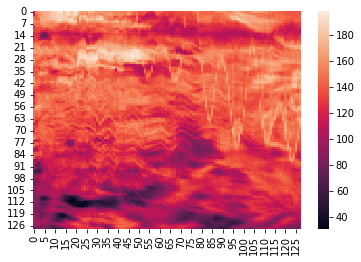

In [5]:
sns.heatmap(dataset_creator_train.images[88][150])

<AxesSubplot:>

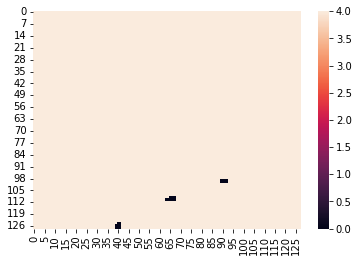

In [6]:
sns.heatmap(dataset_creator_train.masks[88][0])

In [7]:
dataset_creator_train.masks[88].shape, dataset_creator_train.images[88].shape

((1, 128, 128), (237, 128, 128))

In [8]:
np.asarray(dataset_creator_train.masks).max(), np.asarray(dataset_creator_train.masks).min()

(7, 0)

In [15]:
# Test
dataset_creator_test = DatasetCreator(
    PATH_DATA, preprocessing=preprocessing, 
    indices=test_indices, 
    path_old2new=f'{PREFIX_INFO_PATH}/data/index2class.npy'
)

361it [00:14, 25.67it/s]


Preprocess data...
Finish preprocess!


<AxesSubplot:>

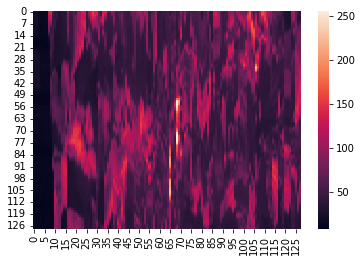

In [16]:
sns.heatmap(dataset_creator_test.images[22][120])

<AxesSubplot:>

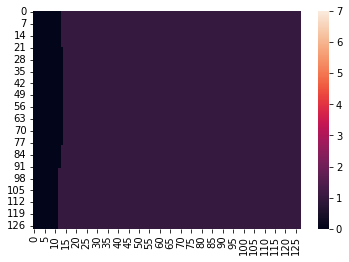

In [17]:
sns.heatmap(dataset_creator_test.masks[22][0], vmin=0, vmax=7)

In [18]:
np.asarray(dataset_creator_test.masks).max(), np.asarray(dataset_creator_test.masks).min()

(7, 0)

In [13]:
# Test
dataset_creator_test_unknown = DatasetCreator(
    PATH_DATA, preprocessing=preprocessing, 
    indices=test_unknown_indices, 
    path_old2new=f'{PREFIX_INFO_PATH}/data/index2class.npy'
)

361it [00:13, 27.06it/s]


Preprocess data...
Finish preprocess!


<AxesSubplot:>

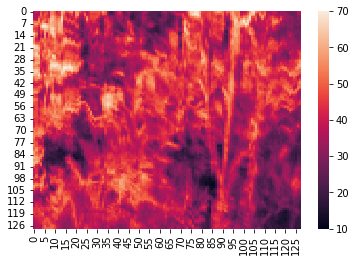

In [14]:
sns.heatmap(dataset_creator_test_unknown.images[44][120])

<AxesSubplot:>

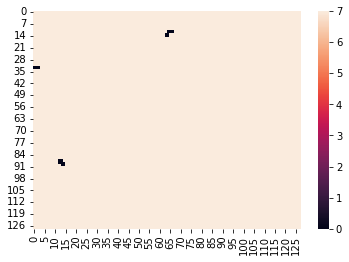

In [15]:
sns.heatmap(dataset_creator_test_unknown.masks[44][0])

In [16]:
np.asarray(dataset_creator_test_unknown.masks).max(), np.asarray(dataset_creator_test_unknown.masks).min()

(7, 0)

In [17]:
PATH_SAVE = f'/raid/rustam/hyperspectral_dataset/diff_exp_with_other__attention_with_other/{KFOLD}'
TYPE_HSI = 'hsi'
TYPE_MASKS = 'masks'
TRAIN_NAME = 'train'
TEST_NAME = 'test'
TEST_UNKNOWN_NAME = 'test_unknown'

def save_image_and_mask(data, part_data: str):
    hsi, mask, indx = data
    np.save(f'{PATH_SAVE}/{part_data}/{TYPE_HSI}/{indx}.npy', hsi)
    np.save(f'{PATH_SAVE}/{part_data}/{TYPE_MASKS}/{indx}.npy', mask)

save_image_and_mask_train = lambda x: save_image_and_mask(x, TRAIN_NAME)
save_image_and_mask_test = lambda x: save_image_and_mask(x, TEST_NAME)
save_image_and_mask_test_unknown = lambda x: save_image_and_mask(x, TEST_UNKNOWN_NAME)

In [18]:
assert len(dataset_creator_train.masks) == len(dataset_creator_train.images)
assert len(dataset_creator_test.masks)  == len(dataset_creator_test.images)

os.makedirs(f'{PATH_SAVE}', exist_ok=True)

os.makedirs(f'{PATH_SAVE}/{TRAIN_NAME}', exist_ok=True)
os.makedirs(f'{PATH_SAVE}/{TRAIN_NAME}/{TYPE_HSI}', exist_ok=True)
os.makedirs(f'{PATH_SAVE}/{TRAIN_NAME}/{TYPE_MASKS}', exist_ok=True)

os.makedirs(f'{PATH_SAVE}/{TEST_NAME}', exist_ok=True)
os.makedirs(f'{PATH_SAVE}/{TEST_NAME}/{TYPE_HSI}', exist_ok=True)
os.makedirs(f'{PATH_SAVE}/{TEST_NAME}/{TYPE_MASKS}', exist_ok=True)

os.makedirs(f'{PATH_SAVE}/{TEST_UNKNOWN_NAME}', exist_ok=True)
os.makedirs(f'{PATH_SAVE}/{TEST_UNKNOWN_NAME}/{TYPE_HSI}', exist_ok=True)
os.makedirs(f'{PATH_SAVE}/{TEST_UNKNOWN_NAME}/{TYPE_MASKS}', exist_ok=True)

with Pool(16) as p:
    list(tqdm(p.imap(
            save_image_and_mask_train, 
            zip(
                dataset_creator_train.images, 
                dataset_creator_train.masks, 
                range(len(dataset_creator_train.masks))
            ),
            #chunksize=1
        ), total=len(dataset_creator_train.masks))
    )
    list(tqdm(p.imap(
            save_image_and_mask_test, 
            zip(
                dataset_creator_test.images, 
                dataset_creator_test.masks, 
                range(len(dataset_creator_test.masks))
            ),
            #chunksize=1
        ), total=len(dataset_creator_test.masks))
    )
    list(tqdm(p.imap(
            save_image_and_mask_test_unknown, 
            zip(
                dataset_creator_test_unknown.images, 
                dataset_creator_test_unknown.masks, 
                range(len(dataset_creator_test_unknown.masks))
            ),
            #chunksize=1
        ), total=len(dataset_creator_test_unknown.masks))
    )

100%|██████████| 1056/1056 [00:08<00:00, 130.45it/s]


<AxesSubplot:>

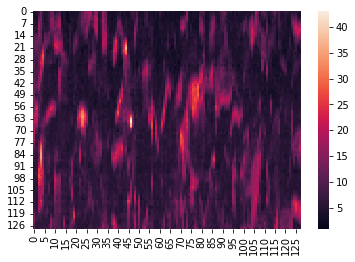

In [22]:
sns.heatmap(np.load(f'{PATH_SAVE}/train/hsi/2.npy')[0])

<AxesSubplot:>

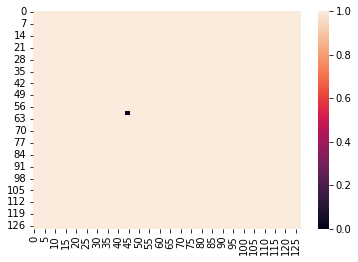

In [23]:
sns.heatmap(np.load(f'{PATH_SAVE}/train/masks/2.npy')[0])

In [21]:
import glob
len(glob.glob(f'{PATH_SAVE}/train/masks/*.npy'))

3600